Data set: https://www.kaggle.com/datasets/elakiricoder/jiffs-house-price-prediction-dataset (house_price_dataset_original_v2_cleaned.csv)

The data set is composed of qualitative and quantitative variables related to houses along with the property value (target). The target variable is removed from the data set as a unsupervised techniques are performed and the target is used only in the end to validade the models' output.

* Steps:
    * The data frame is devided into quantitative and qualitative.
    * MCA (Multiple Correspondency Analysis) is performed at the quantitative data frame where the first n_components' coordinates is returned for each observation. MCA is performed only using qualitative variables that present statistically significant association with at least one other.
    * This data frame is then merged with the quantitative one and KMeans is performed. An F test is performed to checkthe contribution of the features to the cluster formation.
    * The metrics of the houses' variables are then calculated for the resulting clusters and their property value is also compared.

In [1]:
import pandas as pd
import numpy as np
from typing import Tuple, List, Dict
import prince
from scipy.stats import chi2_contingency
import statsmodels.api as sm  
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import matplotlib as mpl
import seaborn as sns
import plotly.graph_objects as go
from platform import python_version
sns.set_context("talk")
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import scipy.stats as stats
import sklearn

import warnings
warnings.simplefilter("ignore")

In [2]:
print('=> Python version used in this Jupyter Notebook:', python_version())
print('=> Package versions used in this Jupyter Notebook')
%reload_ext watermark
%watermark --iversions

=> Python version used in this Jupyter Notebook: 3.10.11
=> Package versions used in this Jupyter Notebook
prince     : 0.10.8
seaborn    : 0.12.2
plotly     : 5.15.0
pandas     : 2.0.2
sklearn    : 1.3.0
scipy      : 1.11.1
matplotlib : 3.7.1
statsmodels: 0.14.0
numpy      : 1.25.0



# Functions

In [96]:
def plot_silhouette_diagram(k_vec,df,kmeans_per_k,silhouette_scores):

    plt.figure(figsize=(14, 12))

    size_k_vec = len(k_vec[1:])
    n_plot = 1
    n_columns = 3
    n_lines = int(size_k_vec/n_columns)

    for k in k_vec[1:]:
        plt.subplot(n_lines, n_columns, n_plot)
        
        y_pred = kmeans_per_k[k - 1].labels_
        silhouette_coefficients = silhouette_samples(df, y_pred)

        padding = len(df) // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()

            color = mpl.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                            facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
        if n_plot in (1, 4, 7, 11, 15):
            plt.ylabel("Cluster")
        
        if k>max(k_vec)-n_columns:
            plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.xlabel("Silhouette Coefficient")
        else:
            plt.tick_params(labelbottom=False)

        plt.xlim(-0.2,1)
        plt.title(f"k={k}, silhouette score: {silhouette_scores[n_plot-1]:.3f}", fontsize=16)

        n_plot +=1

    plt.show()

def test_f_kmeans(kmeans: KMeans, df: pd.DataFrame, alpha: float = 0.05) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
    """
    
    Perform analysis of variance for a factor: 
    Identifies the variables that contribute the most to the formation of at least one cluster.
    
    Parameters
    ----------
    kmeans (KMeans): KMeans object that has been fitted to the data.
    df (pd.DataFrame): DataFrame containing the variables used in the KMeans clustering.
    alpha (float, optional): Significance level for the F-test. Default value is 0.05.
    
    Returns:
    ----------
    Tuple[pd.DataFrame, pd.DataFrame, List[str]]: A tuple containing the centroids DataFrame, the DataFrame with analysis results, and a list of significant features.
    """
    
    df = df.copy()

    variables = df.columns

    centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df.columns)

    unique, counts = np.unique(kmeans.labels_, return_counts=True)

    dic = dict(zip(unique, counts))

    n_clusters = kmeans.n_clusters

    obs = len(kmeans.labels_)

    df['cluster'] = kmeans.labels_

    output = []

    for variable in variables:

        dic_var={'feature':variable}

        # variability between clusters
        variability_between_clusters = np.sum([dic[index]*np.square(obs1 - df[variable].mean())
                                             for index, obs1 in enumerate(centroids[variable])])/(n_clusters - 1)

        dic_var['variability_between_clusters'] = variability_between_clusters

        variability_within_clusters = 0

        for group in unique:

            group = df[df.cluster == group]

            variability_within_clusters += np.sum([np.square(observacao - group[variable].mean()) 
                                                       for observacao in group[variable]])/(obs - n_clusters)

        dic_var['variability_within_clusters'] = variability_within_clusters

        dic_var['F'] =  dic_var['variability_between_clusters']/dic_var['variability_within_clusters']
        
        dic_var['sig F'] =  1 - stats.f.cdf(dic_var['F'], n_clusters - 1, obs - n_clusters)

        dic_var['significant'] = True if dic_var['sig F'] <= alpha else False

        output.append(dic_var)

    df_out = pd.DataFrame(output)

    significant_features = df_out["feature"][df_out["significant"]==True].values

    return centroids, df_out, significant_features

def check_association(
    df_quali: pd.DataFrame, to_print: bool = True, alpha: float = 0.05
) -> Dict[str, bool]:
    """
    Check for association between categorical variables using chi-square test.

    Parameters
    ----------
        - df_quali (pd.DataFrame): DataFrame containing the categorical variables.
        - to_print (bool, optional): Whether to print the results. Defaults to True.
        - alpha (float,optional): significance level of the chi-squared test.
    Returns
    -------
        - Dict[str, bool]: A dictionary where the keys are column names and values are boolean indicating if association is present.
    """

    df_quali = df_quali.copy()
    cols_quali = df_quali.columns

    # initialize association variable for cols_quali
    association = {}
    for col in cols_quali:
        association[f"{col}"] = False

    for i in range(len(cols_quali)):
        keys = [key for key, value in association.items() if value]

        if cols_quali[i] not in keys:
            # iterates over all remaining variables
            for j in range(len(cols_quali)):
                if i != j:
                    cross_tab = pd.crosstab(
                        df_quali[cols_quali[i]], df_quali[cols_quali[j]]
                    )
                    chi2, p_value, dof, expec_freq = chi2_contingency(cross_tab)

                    if p_value <= alpha:
                        if to_print:
                            print(
                                f"Association is statistically significant for: {cols_quali[i]}, {cols_quali[j]}. p-value: {p_value:.3f}"
                            )

                        association[cols_quali[i]] = True
                        association[cols_quali[j]] = True
                        break

    # Lists which variables have association with at least one other
    cols_with_association = []

    for key, value in association.items():
        if value:
            cols_with_association.append(key)
            
    return (association, cols_with_association)

def perform_mca(
    df: pd.DataFrame, n_components: int, categ: list = None
) -> pd.DataFrame:
    """
    Perform Multiple Correspondence Analysis (MCA) on a DataFrame and returns the scaled encoded data frame with mca data concatenated with quantitative data

    Parameters:
    ----------
        - categ (list): List of categorical columns.
        - df (pd.DataFrame): DataFrame containing the transformed data.
        - n_components (int): Number of components for MCA.
    Returns:
    ----------
        - pd.DataFrame: Scaled DataFrame with rows' coordinates after MCA concatenated with the quantitative coordinates of the original data frame
    """

    df = df.copy()

    # -------------------- Set all categorical types as object ------------------- #
    if categ:
        for col in categ:
            df[col] = df[col].astype(object)

    # ------------- Split into qualitative and quantivative variables ------------ #
    df_quanti = df.select_dtypes(exclude=["object"])
    df_quali = df.select_dtypes(include=["object"])

    # ----------- Check for association between quantitative variables ----------- #
    # only those with association with at leat one variable will remain in the data frame
    association, cols_with_association = check_association(
        df_quali, to_print=False
    )

    # ------- Keep only coilumns with statisticaly significant association ------- #
    df_quali = df_quali[cols_with_association]

    # --------------- Calculates the maximum number of eigenvalues --------------- #
    # maximum number of eigenvalues = total number of categories - total number of variables
    total_variables = len(df_quali.columns)
    total_categories = 0

    for column in df_quali.columns:
        total_categories += df_quali[column].nunique()

    maximum_n_components = total_categories - total_variables
    print("Maximum number of components:", maximum_n_components)

    # ----------------------- Perform MCA with n_components ---------------------- #
    mca = prince.MCA(n_components=n_components)
    mca = mca.fit(df_quali)

    print(mca.eigenvalues_summary)

    print(f"Percentage of explained variance {mca.cumulative_percentage_of_variance_[-1]:.1f}%")

    # ----------------- Creates data frame with rows' coordinates ---------------- #
    df_mca = mca.row_coordinates(df_quali)
    df_mca.columns = [f"mca_{i}" for i in range(len(df_mca.columns))]
    df_mca.index.name = "cod_franquia"

    # ------------ Returns df_mca concatenated with df_quanti (if any) ----------- #
    df_encoded = pd.concat([df_mca, df_quanti], axis=1)

    # --------------------------- Scale the data frame --------------------------- #
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_encoded)
    df_scaled = pd.DataFrame(
        df_scaled, columns=df_encoded.columns, index=df_encoded.index
    )

    return df_scaled, mca

# Define Initial Variables

In [4]:
# significance level for statistical tests
alpha = 0.05

# Load the data

source: https://www.kaggle.com/datasets/elakiricoder/jiffs-house-price-prediction-dataset


In [5]:
df_original = pd.read_csv("data/house_price_dataset_original_v2_cleaned.csv")

In [6]:
df_original.head()

,land_size_sqm,house_size_sqm,no_of_rooms,no_of_bathrooms,large_living_room,parking_space,front_garden,swimming_pool,distance_to_school,wall_fence,house_age,water_front,distance_to_supermarket_km,crime_rate_index,room_size,property_value
0,201,177,3,1,0,1,1,0,3.3,1,10,0,6.8,0.90,0,165432
1,196,182,4,3,1,1,0,1,1.2,1,11,0,4.1,1.42,1,187043
2,198,182,4,4,1,1,0,1,5.9,0,20,0,2.1,4.12,1,148658
3,178,166,2,3,0,1,0,0,5.9,0,5,0,0.7,4.36,0,123785
4,183,165,3,1,1,1,0,0,3.8,1,8,0,0.7,0.42,0,156470


In [7]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   land_size_sqm               4954 non-null   int64  
 1   house_size_sqm              4954 non-null   int64  
 2   no_of_rooms                 4954 non-null   int64  
 3   no_of_bathrooms             4954 non-null   int64  
 4   large_living_room           4954 non-null   int64  
 5   parking_space               4954 non-null   int64  
 6   front_garden                4954 non-null   int64  
 7   swimming_pool               4954 non-null   int64  
 8   distance_to_school          4954 non-null   float64
 9   wall_fence                  4954 non-null   int64  
 10  house_age                   4954 non-null   int64  
 11  water_front                 4954 non-null   int64  
 12  distance_to_supermarket_km  4954 non-null   float64
 13  crime_rate_index            4954 

# Data pre-processing

##  Categorical Variables

Room size class: Small(0), Medium(1), Large(2), ExtraLarge (3)\
All the other categorical variables: No(0), Yes(1)

In [8]:
df = df_original.copy()

In [9]:
vars_cat_01 = ['large_living_room','parking_space','front_garden','swimming_pool','wall_fence','water_front']
mapping_01 = {0:'N', 1:'Y'}

cats_cat_0123 = ['room_size']
mapping_0123 = {0:'S', 1:'M', 2:'L', 3:'XL'}

In [10]:
for col in vars_cat_01:
    df[col] = df_original[col].replace(mapping_01)

for col in cats_cat_0123:
    df[col] = df_original[col].replace(mapping_0123)

In [11]:
df.head()

,land_size_sqm,house_size_sqm,no_of_rooms,no_of_bathrooms,large_living_room,parking_space,front_garden,swimming_pool,distance_to_school,wall_fence,house_age,water_front,distance_to_supermarket_km,crime_rate_index,room_size,property_value
0,201,177,3,1,N,Y,Y,N,3.3,Y,10,N,6.8,0.90,S,165432
1,196,182,4,3,Y,Y,N,Y,1.2,Y,11,N,4.1,1.42,M,187043
2,198,182,4,4,Y,Y,N,Y,5.9,N,20,N,2.1,4.12,M,148658
3,178,166,2,3,N,Y,N,N,5.9,N,5,N,0.7,4.36,S,123785
4,183,165,3,1,Y,Y,N,N,3.8,Y,8,N,0.7,0.42,S,156470


## Change the column names to shorter ones (for the perceptual map plot)

In [12]:
cols_names = {'land_size_sqm': 'land_sz',
              'house_size_sqm': 'house_sz',
              'no_of_rooms': 'n_rooms',
              'no_of_bathrooms': 'n_bathr',
              'large_living_room': 'l_living_r',
              'parking_space': 'parking',
              'front_garden': 'f_garden',
              'swimming_pool': 'swim_p',
              'distance_to_school': 'dist_school',
              'wall_fence': 'wall_f',
              'house_age': 'house_age',
              'water_front': 'water_f',
              'distance_to_supermarket_km': 'dist_mkt',
              'crime_rate_index': 'crime_idx',
              'room_size': 'room_sz',
              }


df = df.rename(columns=cols_names)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   land_sz         4954 non-null   int64  
 1   house_sz        4954 non-null   int64  
 2   n_rooms         4954 non-null   int64  
 3   n_bathr         4954 non-null   int64  
 4   l_living_r      4954 non-null   object 
 5   parking         4954 non-null   object 
 6   f_garden        4954 non-null   object 
 7   swim_p          4954 non-null   object 
 8   dist_school     4954 non-null   float64
 9   wall_f          4954 non-null   object 
 10  house_age       4954 non-null   int64  
 11  water_f         4954 non-null   object 
 12  dist_mkt        4954 non-null   float64
 13  crime_idx       4954 non-null   float64
 14  room_sz         4954 non-null   object 
 15  property_value  4954 non-null   int64  
dtypes: float64(3), int64(6), object(7)
memory usage: 619.4+ KB


In [109]:
df.head()

,land_sz,house_sz,n_rooms,n_bathr,l_living_r,parking,f_garden,swim_p,dist_school,wall_f,house_age,water_f,dist_mkt,crime_idx,room_sz,property_value
0,201,177,3,1,N,Y,Y,N,3.3,Y,10,N,6.8,0.90,S,165432
1,196,182,4,3,Y,Y,N,Y,1.2,Y,11,N,4.1,1.42,M,187043
2,198,182,4,4,Y,Y,N,Y,5.9,N,20,N,2.1,4.12,M,148658
3,178,166,2,3,N,Y,N,N,5.9,N,5,N,0.7,4.36,S,123785
4,183,165,3,1,Y,Y,N,N,3.8,Y,8,N,0.7,0.42,S,156470


# Split into qulitative and quantitative data frames

In [14]:
df_quanti = df.select_dtypes(exclude=['object'])
df_quali = df.select_dtypes(include=['object'])

In [15]:
df_quali.head()

,l_living_r,parking,f_garden,swim_p,wall_f,water_f,room_sz
0,N,Y,Y,N,Y,N,S
1,Y,Y,N,Y,Y,N,M
2,Y,Y,N,Y,N,N,M
3,N,Y,N,N,N,N,S
4,Y,Y,N,N,Y,N,S


In [16]:
df_quali.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   l_living_r  4954 non-null   object
 1   parking     4954 non-null   object
 2   f_garden    4954 non-null   object
 3   swim_p      4954 non-null   object
 4   wall_f      4954 non-null   object
 5   water_f     4954 non-null   object
 6   room_sz     4954 non-null   object
dtypes: object(7)
memory usage: 271.0+ KB


In [17]:
df_quali.apply(pd.value_counts).fillna(0).astype(int)

,l_living_r,parking,f_garden,swim_p,wall_f,water_f,room_sz
L,0,0,0,0,0,0,1779
M,0,0,0,0,0,0,1460
N,1368,1170,1845,1894,1831,4713,0
S,0,0,0,0,0,0,517
XL,0,0,0,0,0,0,1198
Y,3586,3784,3109,3060,3123,241,0


In [18]:
df_quanti.head()

,land_sz,house_sz,n_rooms,n_bathr,dist_school,house_age,dist_mkt,crime_idx,property_value
0,201,177,3,1,3.3,10,6.8,0.90,165432
1,196,182,4,3,1.2,11,4.1,1.42,187043
2,198,182,4,4,5.9,20,2.1,4.12,148658
3,178,166,2,3,5.9,5,0.7,4.36,123785
4,183,165,3,1,3.8,8,0.7,0.42,156470


In [19]:
df_quanti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   land_sz         4954 non-null   int64  
 1   house_sz        4954 non-null   int64  
 2   n_rooms         4954 non-null   int64  
 3   n_bathr         4954 non-null   int64  
 4   dist_school     4954 non-null   float64
 5   house_age       4954 non-null   int64  
 6   dist_mkt        4954 non-null   float64
 7   crime_idx       4954 non-null   float64
 8   property_value  4954 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 348.5 KB


In [20]:
df_quanti.describe()

,land_sz,house_sz,n_rooms,n_bathr,dist_school,house_age,dist_mkt,crime_idx,property_value
count,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000
mean,250.131409,231.250908,3.788252,3.199839,3.454219,11.444691,3.508639,2.986110,201974.738999
std,103.131939,94.571642,1.585371,1.602300,2.007358,6.356991,1.991266,1.737742,90031.882219
min,100.000000,85.000000,1.000000,1.000000,0.100000,1.000000,0.100000,0.010000,32622.000000
25%,180.000000,165.000000,3.000000,2.000000,1.700000,6.000000,1.800000,1.470000,136777.000000
50%,235.000000,217.500000,4.000000,3.000000,3.400000,11.000000,3.500000,3.020000,194515.500000
75%,295.000000,274.000000,5.000000,4.000000,5.200000,17.000000,5.300000,4.490000,246590.000000
max,796.000000,760.000000,8.000000,9.000000,6.900000,22.000000,6.900000,5.990000,692086.000000


# Save the property_value as y and remove it from df_quanti

The target variable property_value will not be used in training, it will be used at the end to compare the models' results

In [21]:
y = df_quanti["property_value"]

df_quanti.drop("property_value",axis=1,inplace=True)

# Multiple correspondence analysis, MCA

## Check if each of the qualitative variable has statistically significant association with at least one other

In [22]:
association, cols_with_association = check_association(df_quali)

Association is statistically significant for: l_living_r, parking. p-value: 0.000
Association is statistically significant for: f_garden, l_living_r. p-value: 0.000
Association is statistically significant for: swim_p, l_living_r. p-value: 0.000
Association is statistically significant for: wall_f, l_living_r. p-value: 0.000
Association is statistically significant for: water_f, l_living_r. p-value: 0.003
Association is statistically significant for: room_sz, l_living_r. p-value: 0.000


In [23]:
print(f"Number of original variables: {df_quali.shape[1]}")
print(f"Number of variables that present statistically significant association with at tleast one other and are used to perform MCA: {len(cols_with_association)}")

Number of original variables: 7
Number of variables that present statistically significant association with at tleast one other and are used to perform MCA: 7


## Keep only those columns that have association with at least one other variable

In [24]:
df_quali = df_quali[cols_with_association]

## Perform MCA

In [25]:
# the maximum number of eigenvalues: total number of categories - total number of variables 

total_variables = len(df_quali.columns)
total_categories = 0

for column in df_quali.columns:
    total_categories += df_quali[column].nunique()

maximum_n_components = total_categories - total_variables

print("Maximum number of components:", maximum_n_components)

Maximum number of components: 9


In [26]:
# performing MCA and returning the first 3 components

mca = prince.MCA(n_components=3)
mca = mca.fit(df_quali)

### Coordinates of the categories

In [27]:
coord_categories = mca.column_coordinates(df_quali)
coord_categories

,0,1,2
l_living_r_N,0.976380,-0.095572,-0.036464
l_living_r_Y,-0.372473,0.036459,0.013910
parking_N,1.205710,0.064914,0.037254
parking_Y,-0.372802,-0.020071,-0.011519
f_garden_N,0.909825,-0.019481,0.035850
f_garden_Y,-0.539925,0.011561,-0.021275
swim_p_N,0.886997,0.058291,-0.000753
swim_p_Y,-0.549011,-0.036080,0.000466
wall_f_N,0.868065,0.036232,-0.043379
wall_f_Y,-0.508942,-0.021243,0.025433


### Coordinates of the observations - They will be used in Kmeans Clustering

In [140]:
coord_obs = mca.row_coordinates(df_quali)
coord_obs.columns= ["mca1","mca2","mca3"]
coord_obs.head()

,mca1,mca2,mca3
0,0.369421,0.317828,0.427218
1,-0.141592,-0.447006,-0.029203
2,0.189233,-0.425518,-0.055200
3,1.048545,0.327711,0.422802
4,0.393661,0.355585,0.467830


### Eigenvalues and percentage of explained variance

Aproximatelly 50% of the total variance of the original df is explained by the first 3 components

In [29]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.354,27.50%,27.50%
1,0.146,11.36%,38.86%
2,0.143,11.12%,49.98%


In [30]:
# list of the greatest eigenvalues
mca.eigenvalues_

array([0.35357551, 0.14600528, 0.14298755])

In [31]:
# percentage of explained variance 
var_pct = mca.percentage_of_variance_
var_pct

array([27.50031747, 11.35596613, 11.1212538 ])

In [32]:
# cumulative percentage of explained variance 
mca.cumulative_percentage_of_variance_

array([27.50031747, 38.85628359, 49.9775374 ])

## Contributions

In [33]:
# Contributions of each row to the explained variance of each column
(
    mca.row_contributions_
    .sort_values(0, ascending=False)
    .head(5)
    .style.format('{:.3%}')
)

,0,1,2
3420,0.116%,0.018%,0.027%
413,0.116%,0.018%,0.027%
1142,0.116%,0.018%,0.027%
3246,0.116%,0.018%,0.027%
3298,0.116%,0.018%,0.027%


In [34]:
# Contribution of each category to the explained variance of each column
mca.column_contributions_.style.format('{:.0%}')

,0,1,2
l_living_r_N,11%,0%,0%
l_living_r_Y,4%,0%,0%
parking_N,14%,0%,0%
parking_Y,4%,0%,0%
f_garden_N,12%,0%,0%
f_garden_Y,7%,0%,0%
swim_p_N,12%,0%,0%
swim_p_Y,8%,0%,0%
wall_f_N,11%,0%,0%
wall_f_Y,7%,0%,0%


## Perceptual Map

In [35]:
plt.figure(figsize=(14, 8)) 
mca.plot(X=df_quali, x_component=0, y_component=1)

alt.Chart(...)

<Figure size 1400x800 with 0 Axes>

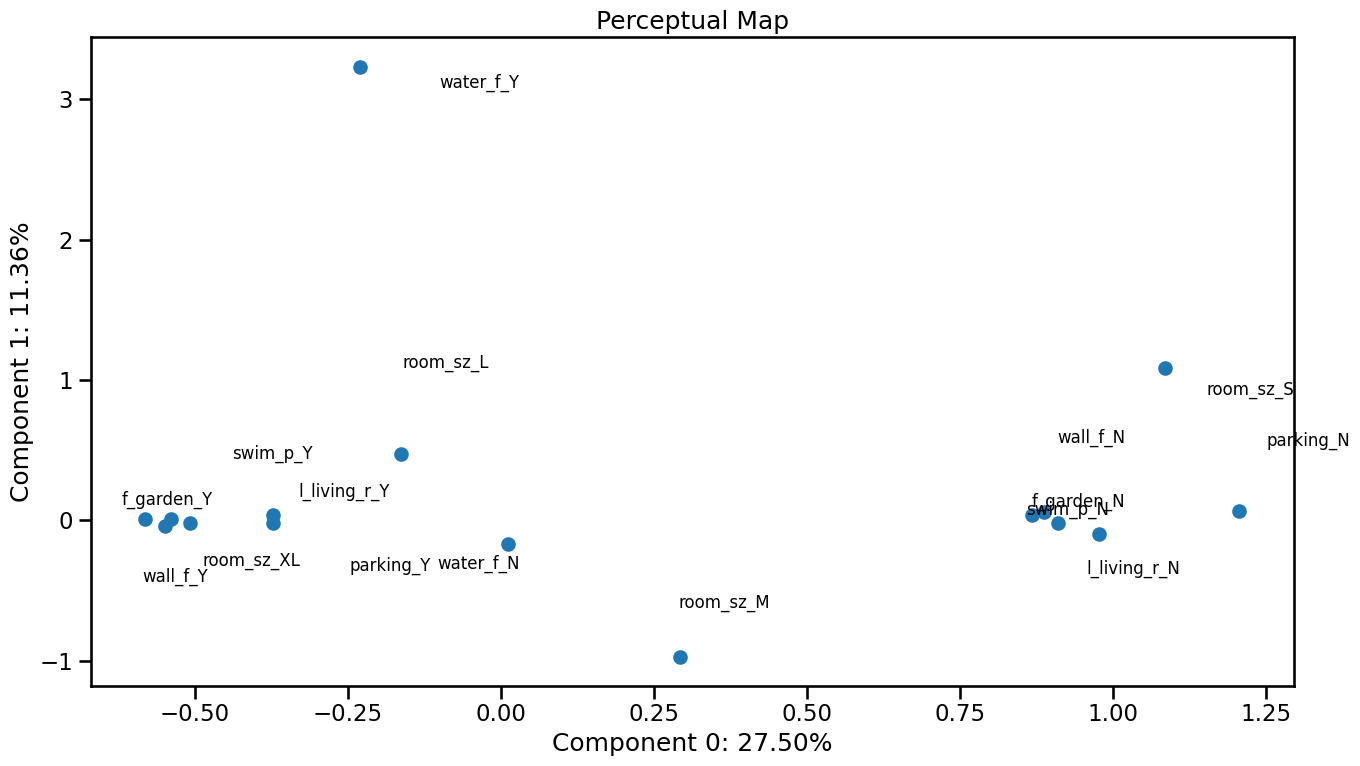

In [139]:
# Run it several times until the labels are not on top of each other as their location is random

plt.figure(figsize=(14, 8))  # Set the figure size

plt.scatter(coord_categories[0], coord_categories[1])

 # Add labels with annotations
for i, label in enumerate(coord_categories.index):
    offset_x = random.randint(-60, 60)  # Random x offset
    offset_y = random.randint(-60, 60)  # Random y offset
    plt.annotate(label, (coord_categories[0][i], coord_categories[1][i]), textcoords="offset points", xytext=(offset_x, offset_y), ha='left', va='bottom',fontsize=12)


plt.xlabel(f'Component 0: {var_pct[0]:.2f}%')
plt.ylabel(f'Component 1: {var_pct[1]:.2f}%')
plt.title('Perceptual Map')
plt.tight_layout() 

plt.show()

In [37]:
# Create a scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=coord_categories[0],
    y=coord_categories[1],
    z=coord_categories[2],
    mode='markers',
    text=coord_categories.index,
    marker=dict(
        size=5,
        color='blue',
        opacity=0.8
    )
)])

 # Set labels for the x, y, and z axes
fig.update_layout(scene=dict(
    xaxis_title=f'Component 0: {var_pct[0]:.2f}%',
    yaxis_title=f'Component 1: {var_pct[1]:.2f}%',
    zaxis_title=f'Component 2: {var_pct[2]:.2f}%'
))
 # Show the interactive plot
plt.tight_layout()
fig.show()

<Figure size 640x480 with 0 Axes>

# Kmeans Clustering

## Adding the new variables to the quantitative data frame

In [38]:


df_quanti = pd.concat([df_quanti,coord_obs],axis=1)

In [39]:
df_quanti.head()

,land_sz,house_sz,n_rooms,n_bathr,dist_school,house_age,dist_mkt,crime_idx,mca1,mca2,mca3
0,201,177,3,1,3.3,10,6.8,0.90,0.369421,0.317828,0.427218
1,196,182,4,3,1.2,11,4.1,1.42,-0.141592,-0.447006,-0.029203
2,198,182,4,4,5.9,20,2.1,4.12,0.189233,-0.425518,-0.055200
3,178,166,2,3,5.9,5,0.7,4.36,1.048545,0.327711,0.422802
4,183,165,3,1,3.8,8,0.7,0.42,0.393661,0.355585,0.467830


## Scale the features

In [40]:
scaler = StandardScaler().set_output(transform="pandas")

df_scaled = scaler.fit_transform(df_quanti)

In [41]:
df_scaled.head()

,land_sz,house_sz,n_rooms,n_bathr,dist_school,house_age,dist_mkt,crime_idx,mca1,mca2,mca3
0,-0.476442,-0.573707,-0.497254,-1.373064,-0.076835,-0.227283,1.653066,-1.200593,0.621270,0.831780,1.129796
1,-0.524928,-0.520831,0.133577,-0.124732,-1.123092,-0.069960,0.297007,-0.901324,-0.238120,-1.169846,-0.077228
2,-0.505534,-0.520831,0.133577,0.499433,1.218531,1.345947,-0.707481,0.652573,0.318240,-1.113611,-0.145978
3,-0.699480,-0.690032,-1.128084,-0.124732,1.218531,-1.013898,-1.410622,0.790698,1.763381,0.857643,1.118119
4,-0.650993,-0.700607,-0.497254,-1.373064,0.172274,-0.541929,-1.410622,-1.476841,0.662036,0.930593,1.237197


## Choosing the most appropriate number of clusters

In [42]:
k_vec = np.arange(1,11,1)

kmeans_per_k = [KMeans(n_clusters=k, random_state=123).fit(df_scaled) for k in k_vec]

### Inertia

Measures the distance between each instance and its centroid.

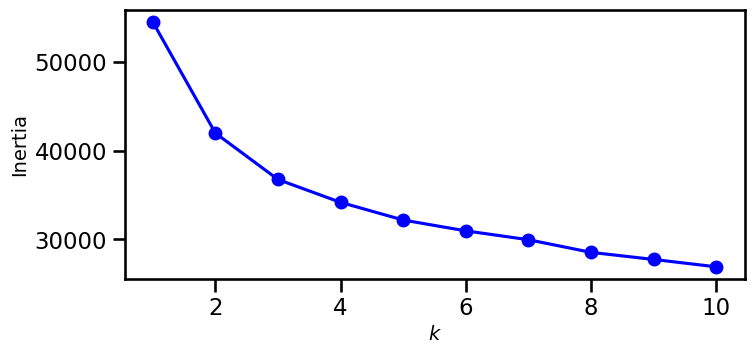

In [43]:
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(k_vec, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

#plt.axis([1, 8.5, 0, 1300])
plt.show()

### Silhouette Score

 The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

In [44]:
silhouette_scores = [silhouette_score(df_scaled, model.labels_) for model in kmeans_per_k[1:]]

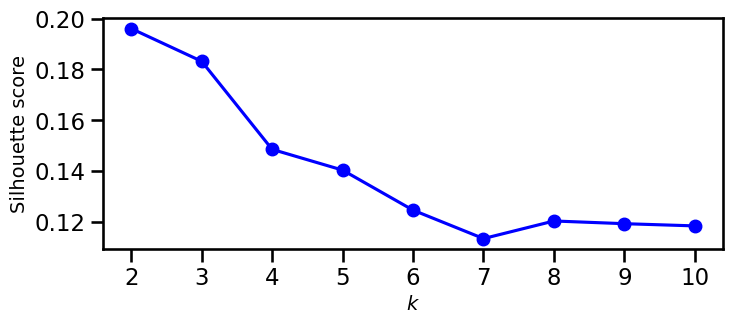

In [45]:
plt.figure(figsize=(8, 3))
plt.plot(k_vec[1:], silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

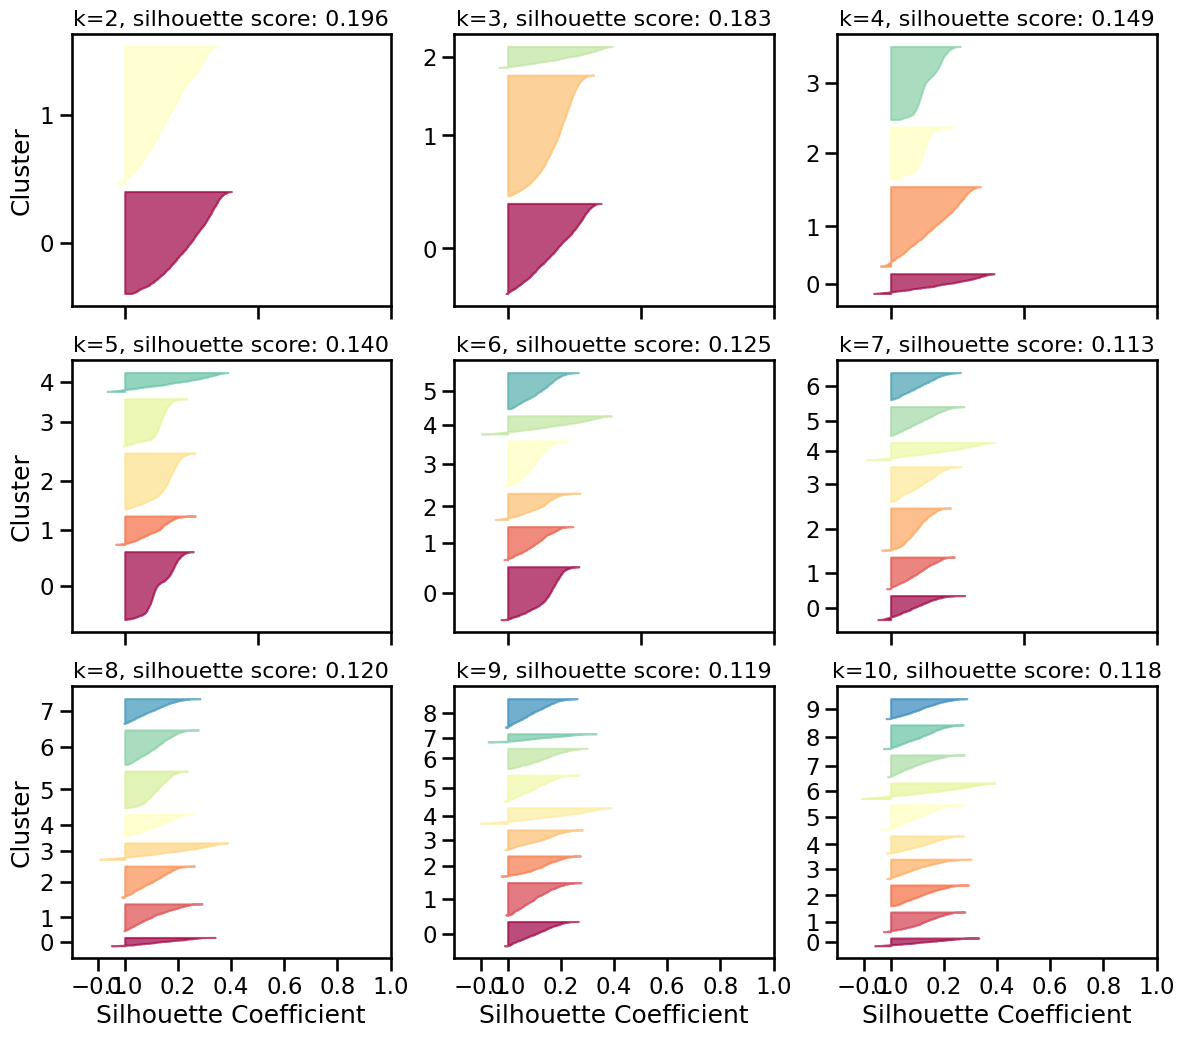

In [46]:
# silhouette diagram
plot_silhouette_diagram(k_vec,df_scaled,kmeans_per_k,silhouette_scores)

## K = 3 will be chosen as it presents a high value of the silhouete score, while minimizing the inertia

In [47]:
kmeans = KMeans(n_clusters = 3, random_state=123).fit(df_scaled)
kmeans

KMeans(n_clusters=3, random_state=123)

## Checking which variables contributed to the cluster formation

Test F for variance analysis.   

$F = \frac{\text{variability between clusters}}{\text{variability within clusters}}$ 

* Analysing the F statiistic value in df_f_test, one sees that the most important features in cluster formation were no_of_rooms, land_size_sqm, house_size_sqm and mca1, respectivelly.
* The features distance_to_school and mca3 were not significant in cluster formation

In [48]:
centroids, df_f_test, significant_features = test_f_kmeans(kmeans,df_scaled,alpha)

In [49]:
df_f_test

,feature,variability_between_clusters,variability_within_clusters,F,sig F,significant
0,land_sz,1910.386748,0.228888,8346.367426,1.110223e-16,True
1,house_sz,1892.215111,0.236229,8010.088148,1.110223e-16,True
2,n_rooms,1947.276866,0.213986,9100.006340,1.110223e-16,True
3,n_bathr,1290.906281,0.479133,2694.254634,1.110223e-16,True
4,dist_school,1.150306,1.000141,1.150143,3.166760e-01,False
5,house_age,3.446054,0.999214,3.448766,3.186123e-02,True
6,dist_mkt,3.768765,0.999084,3.772222,2.306704e-02,True
7,crime_idx,1.120641,1.000153,1.120469,3.262095e-01,False
8,mca1,1805.882635,0.271104,6661.223047,1.110223e-16,True
9,mca2,16.596733,0.993902,16.698569,5.919077e-08,True


In [50]:
significant_features

array(['land_sz', 'house_sz', 'n_rooms', 'n_bathr', 'house_age',
       'dist_mkt', 'mca1', 'mca2'], dtype=object)

## Adding the cluster labels and the target to the original quantitative data frame

In [51]:
df_quanti["cluster_label"] = kmeans.labels_
df_scaled["cluster_label"] = kmeans.labels_

In [52]:
df_quanti['property_value'] = y

In [53]:
df_quanti.head()

,land_sz,house_sz,n_rooms,n_bathr,dist_school,house_age,dist_mkt,crime_idx,mca1,mca2,mca3,cluster_label,property_value
0,201,177,3,1,3.3,10,6.8,0.90,0.369421,0.317828,0.427218,0,165432
1,196,182,4,3,1.2,11,4.1,1.42,-0.141592,-0.447006,-0.029203,1,187043
2,198,182,4,4,5.9,20,2.1,4.12,0.189233,-0.425518,-0.055200,1,148658
3,178,166,2,3,5.9,5,0.7,4.36,1.048545,0.327711,0.422802,0,123785
4,183,165,3,1,3.8,8,0.7,0.42,0.393661,0.355585,0.467830,0,156470


## Plot

3D plot of the three features that most contributed to cluster formation. The cluster centroids are represented by stars

In [54]:
centroids

,land_sz,house_sz,n_rooms,n_bathr,dist_school,house_age,dist_mkt,crime_idx,mca1,mca2,mca3
0,-0.811545,-0.812461,-0.978806,-0.717479,-0.004468,0.012253,0.034469,-0.022329,1.060769,0.029415,-0.007326
1,0.199471,0.203809,0.398688,0.221623,0.014206,-0.027043,-0.036731,0.020427,-0.614965,-0.060648,-0.004195
2,2.332908,2.311993,1.908315,1.803247,-0.062220,0.102396,0.062738,-0.021358,-1.020749,0.221347,0.055394


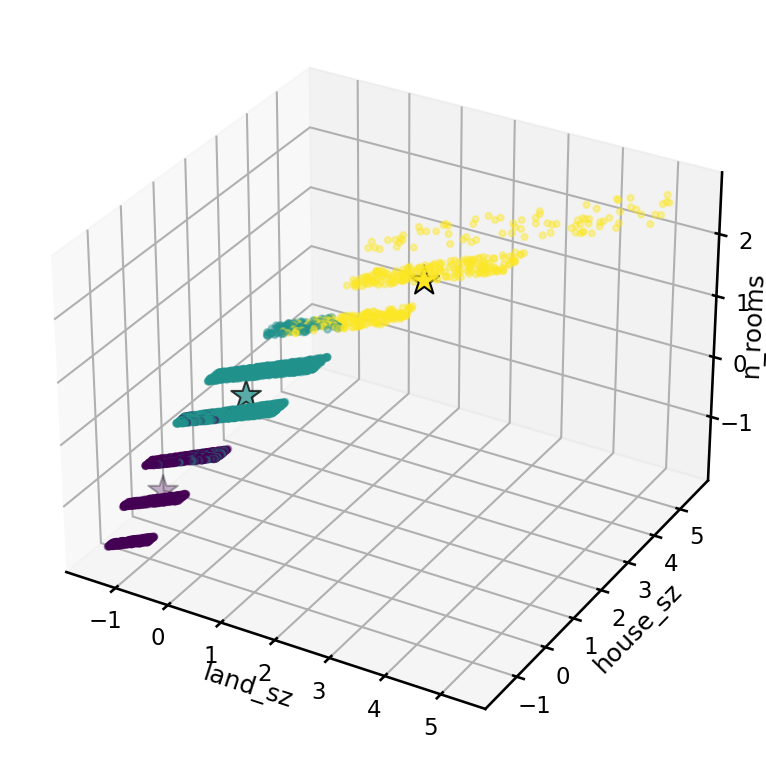

In [55]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
 
# Scatter plot of variables with color based on cluster label
ax.scatter(df_scaled.loc[:, significant_features[0]], df_scaled.loc[:, significant_features[1]], df_scaled.loc[:, significant_features[2]], c=df_scaled.loc[:,'cluster_label'],alpha=0.4) # the data
ax.scatter(centroids.loc[:,significant_features[0]], centroids.loc[:,significant_features[1]], centroids.loc[:,significant_features[2]],marker='*',s=500, edgecolor='black', c=centroids.index) # the centroids 
ax.set_xlabel(significant_features[0])
ax.set_ylabel(significant_features[1])
ax.set_zlabel(significant_features[2])
ax.zaxis.labelpad=-3.5
plt.tight_layout()
plt.show()

## How the cluster labels relate to the unseen target variable

In [56]:
df_quanti.groupby('cluster_label')['property_value'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_label,,,,,,,,
0,1927.0,122860.858329,33402.823849,32622.0,96509.0,122585.0,148116.00,224372.0
1,2577.0,226478.001552,38893.710100,109291.0,198286.0,224761.0,253437.00,350032.0
2,450.0,400435.940000,78538.801660,264906.0,346496.0,382336.0,435340.75,692086.0


<Axes: xlabel='cluster_label', ylabel='property_value'>

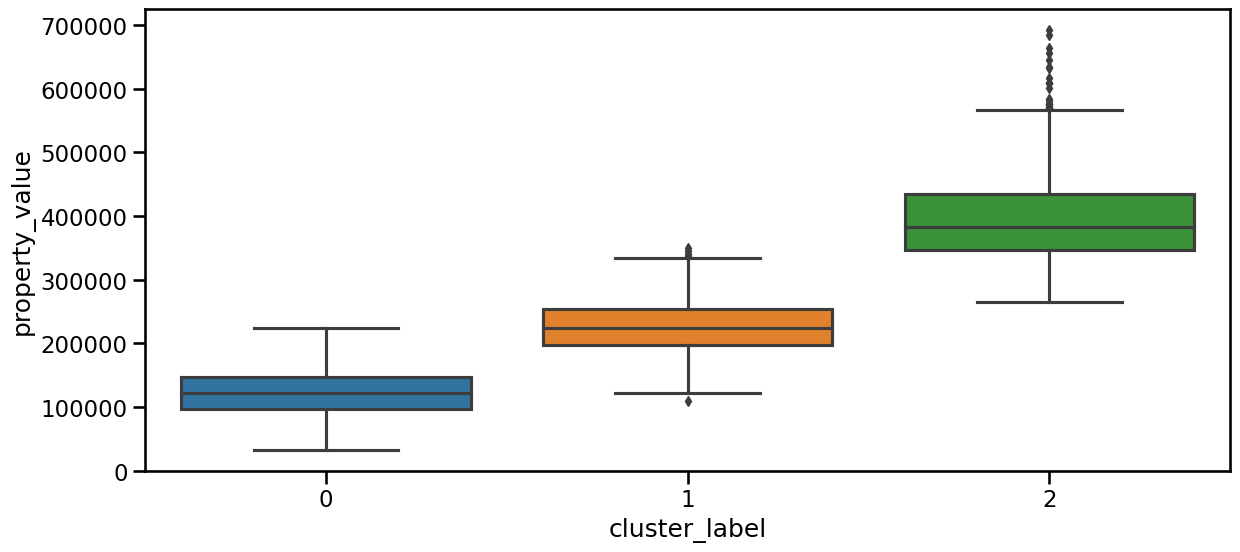

In [57]:
fig, ax = plt.subplots(figsize=(14,6))

sns.boxplot(x='cluster_label', y='property_value',data=df_quanti,showfliers=True,ax=ax)

## Description of the other features as a function of the cluster labels - only the significant ones

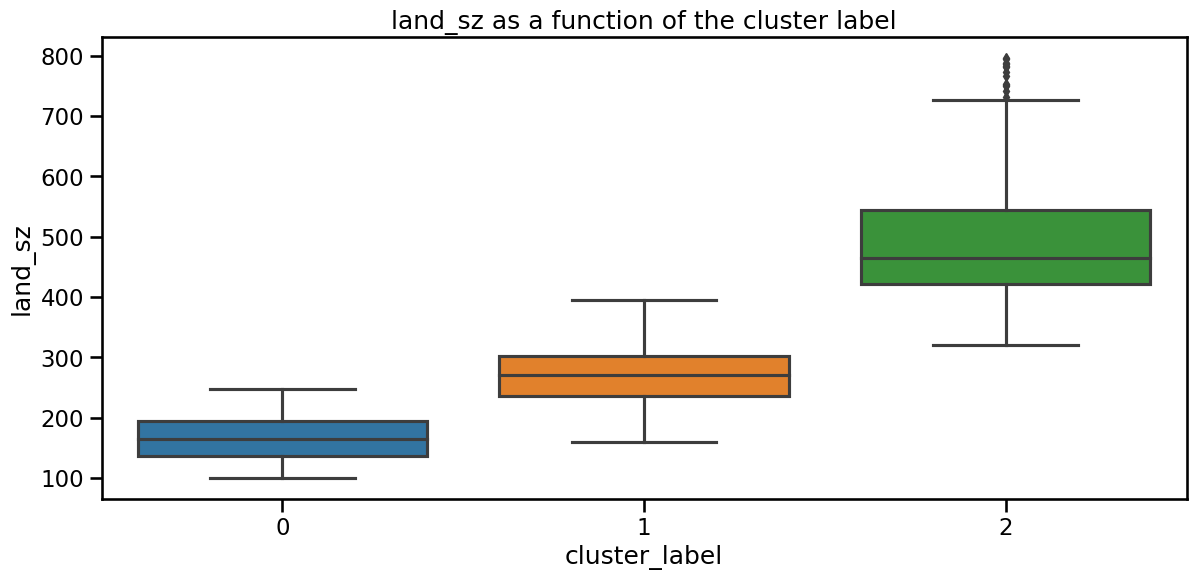

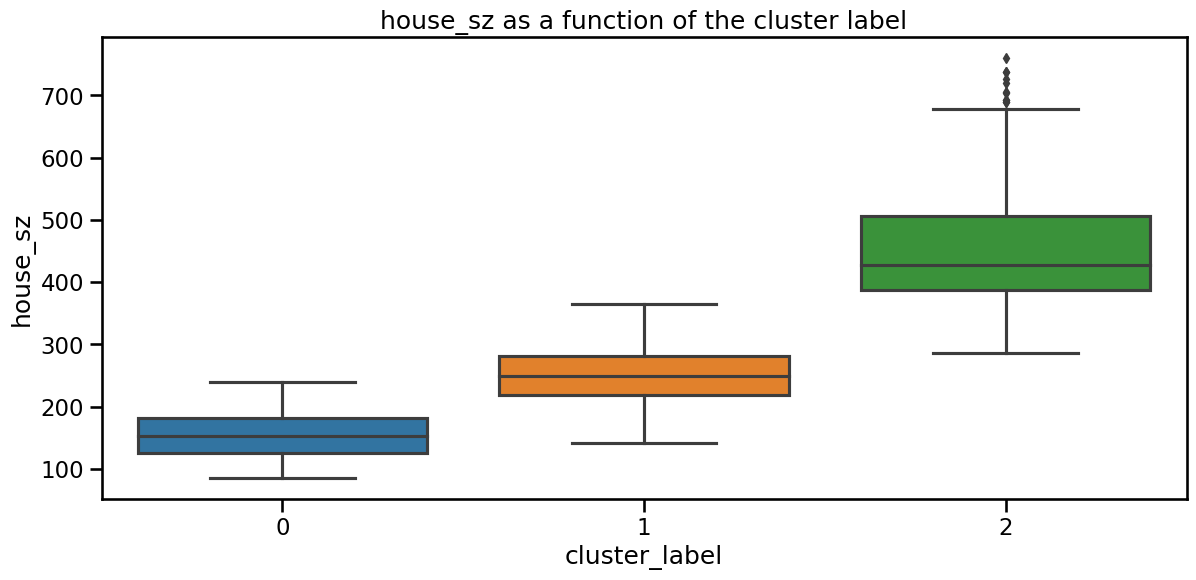

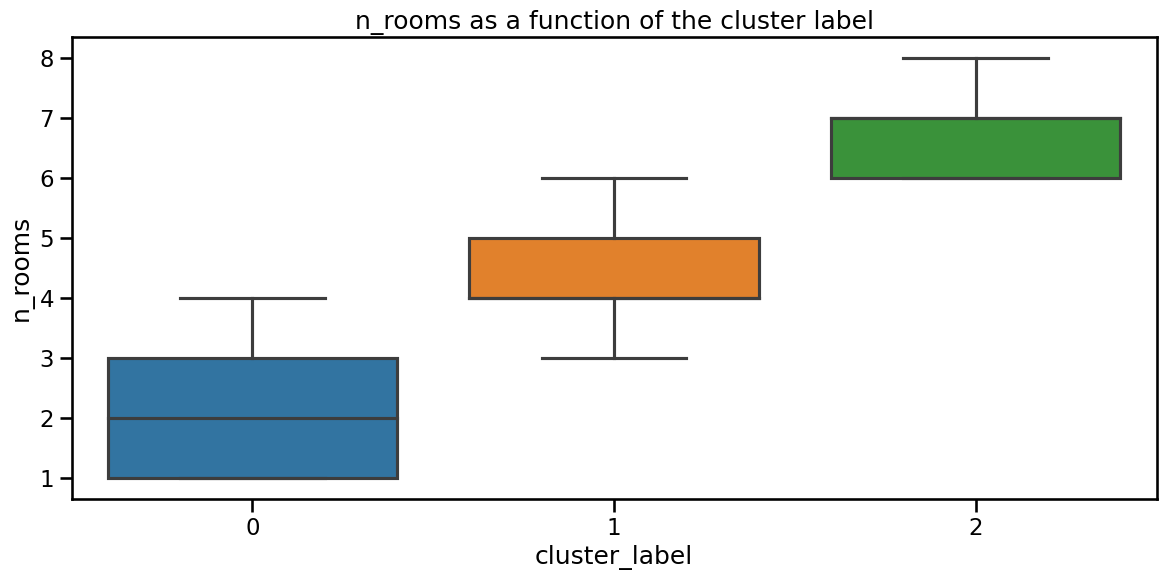

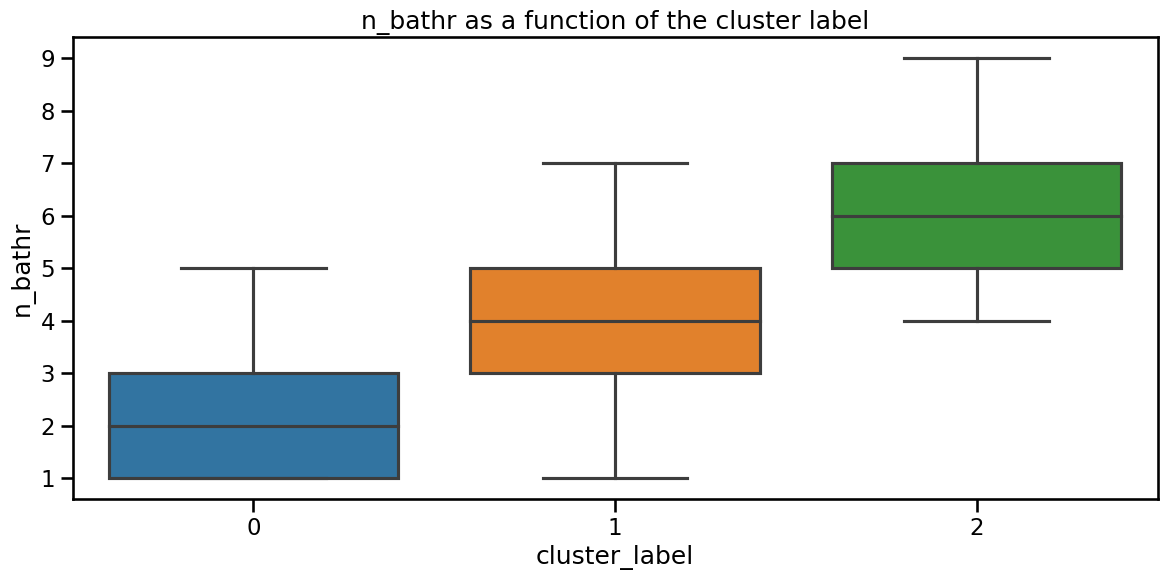

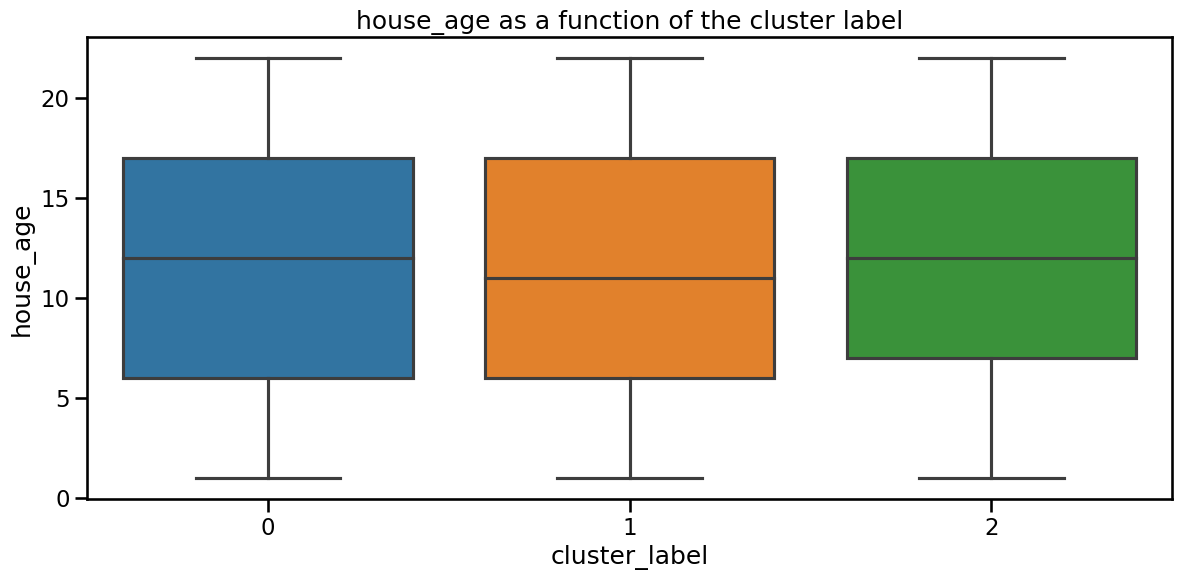

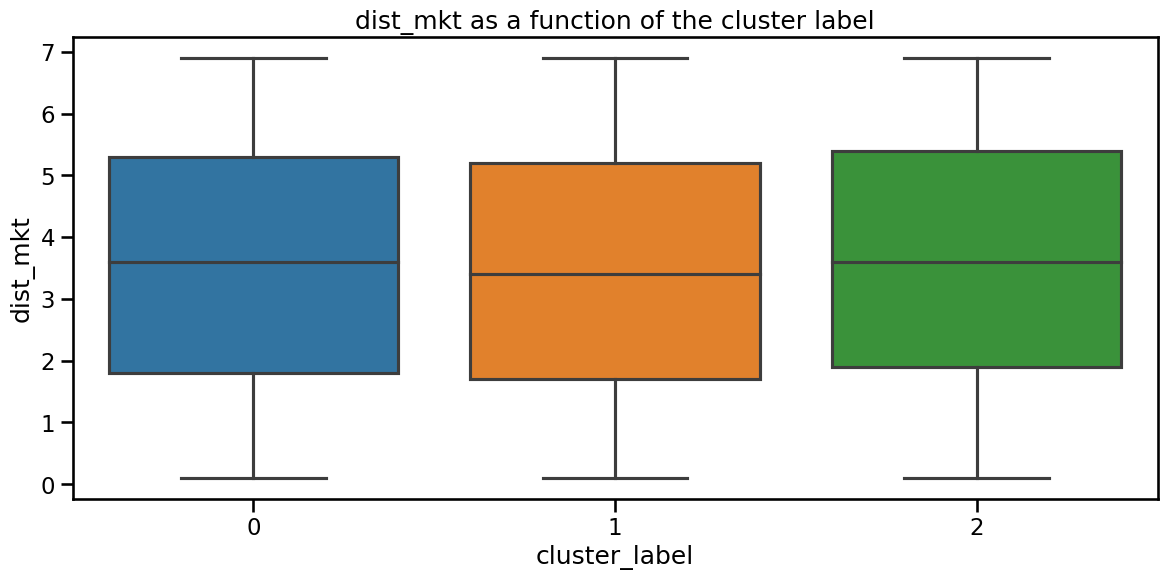

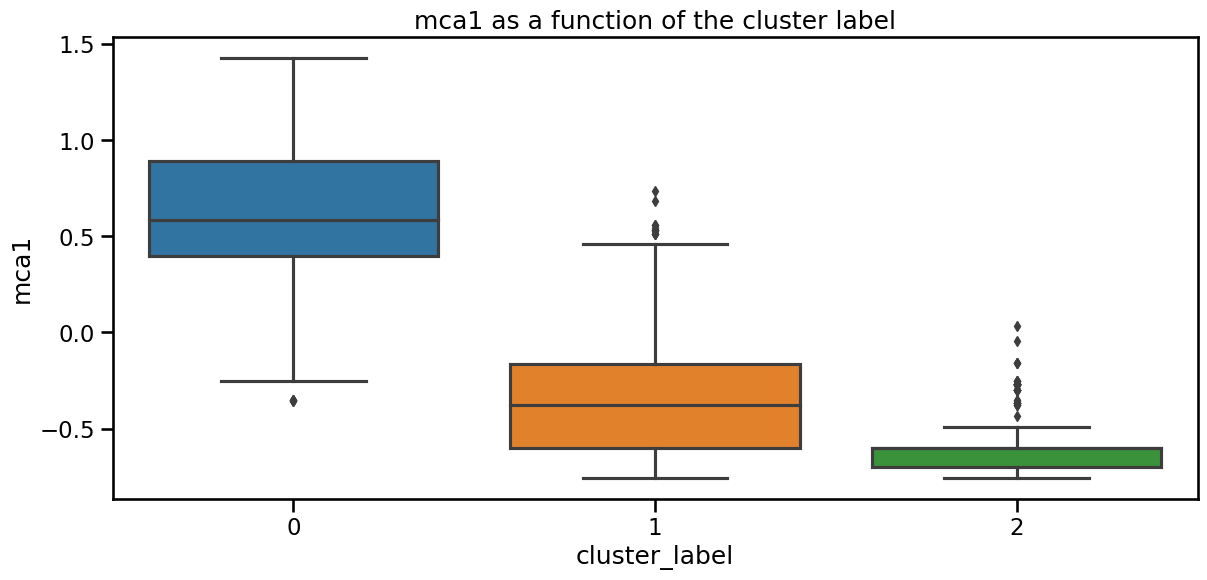

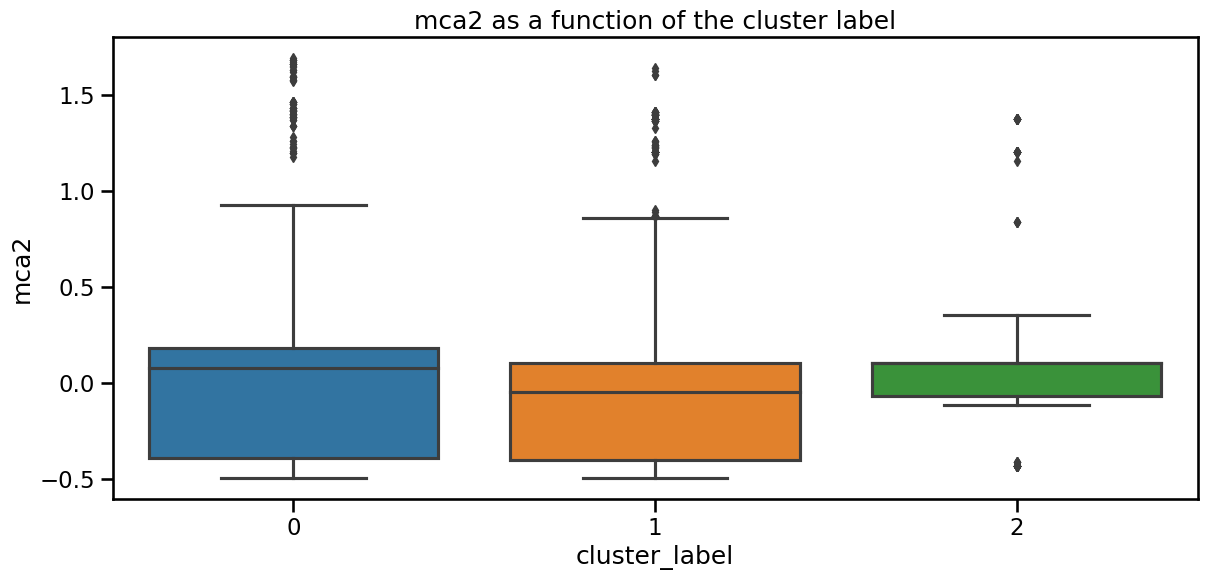

In [58]:

for feature in significant_features:
    fig, ax = plt.subplots(figsize=(14,6))

    sns.boxplot(x='cluster_label', y=feature,data=df_quanti,showfliers=True,ax=ax)
    plt.title(f'{feature} as a function of the cluster label')
    plt.show()